
# Практика 3


## Выполнил студент группы ББМО-01-23 Егоров Юрий Александрович

### Пункт 1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.9733 - loss: 0.0970
Test accuracy on clean images: 0.9768000245094299


## 2. Теоретическая часть: Атака Carlini-Wagner
- Атака Carlini-Wagner (CW) оптимизирует изображение, минимально изменяя его, чтобы модель дала неверный результат.
- Цель атаки — сделать модификации настолько незаметными, что изображение всё ещё выглядит как исходное, но классифицируется неправильно.
- Особенность CW атаки заключается в минимизации изменений с использованием разных норм (L2, L0, L∞), что делает её более точной по сравнению с другими атаками.

### Пункт 3


In [3]:
pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00


tf.Tensor(7, shape=(), dtype=int64)


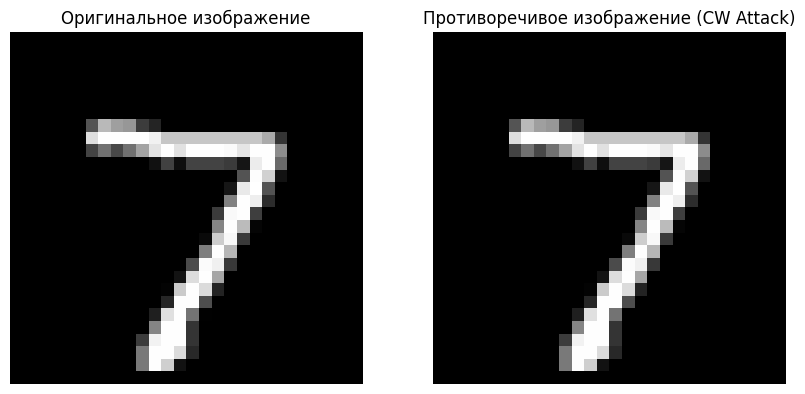

In [8]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Обратите внимание на смену диапазона bounds и нормализацию изображения
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Убедитесь, что изображение нормализовано в диапазоне [0, 1]
image = tf.convert_to_tensor(test_images[0] / 255.0, dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Увеличьте число шагов для атаки CW
attack = fb.attacks.L2CarliniWagnerAttack(steps=50)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()


### Пункт 4 Оценка модели на противоречивых примерах

In [10]:
import tensorflow as tf
import numpy as np

# Список для хранения противоречивых изображений
adversarial_images = []

# Перебор каждого тестового изображения и создание противоречивого примера
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]  # Добавляем размерность батча
    label = np.argmax(test_labels[i])  # Получаем индекс метки как скаляр
    label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

    # Выполнение атаки для создания противоречивого примера
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Добавляем размерность батча к метке
    adversarial_images.append(advs[0])  # Добавляем противоречивое изображение без лишней размерности батча

# Объединяем все противоречивые изображения вдоль оси батча
adversarial_images = tf.stack(adversarial_images, axis=0)  # Используем stack для одинаковой формы
test_labels_tensor = tf.convert_to_tensor([np.argmax(lbl) for lbl in test_labels], dtype=tf.int64)  # Целочисленные метки

# Преобразуем метки в формат one-hot для корректного ранга
num_classes = model.output_shape[-1]  # Определяем количество классов по выходной форме модели
test_labels_one_hot = tf.one_hot(test_labels_tensor, depth=num_classes)

# Оцениваем точность модели на противоречивых изображениях
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels_one_hot)
print(f'Точность на противоречивых примерах (Carlini-Wagner): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.0631 - loss: 2.0271
Точность на противоречивых примерах (Carlini-Wagner): 0.06629999727010727


### Вывод 

Точность снизилась до 6.3%, можно сделать вывод, что атака выполнена успешно